In [132]:
import matplotlib.pyplot as plt
import wfdb
import numpy as np

In [133]:
from utils import *

In [134]:
data_dir = "data/mit-bih-arrhythmia-database-1.0.0/"
record_name = "207"

rec = read_record(f"{data_dir}{record_name}")

In [135]:
sig = rec.p_signal
ann = read_annotation(f"{data_dir}{record_name}")

# sig = sig - sig.mean()  # Normalize

High pass filter to remove noise

In [136]:
from scipy.signal import butter, lfilter

def apply_high_pass_filter(signal, cutoff_freq, fs, order=4):
    """
    Applies a high-pass Butterworth filter to the signal.
    
    Parameters:
    - signal: Input ECG signal (1D array).
    - cutoff_freq: Cutoff frequency of the filter in Hz.
    - fs: Sampling frequency of the signal in Hz.
    - order: Order of the Butterworth filter (default is 4).
    
    Returns:
    - filtered_signal: Signal after high-pass filtering.
    """
    # Normalize the cutoff frequency to the Nyquist frequency
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff_freq / nyquist

    # Design the Butterworth high-pass filter
    b, a = butter(order, normalized_cutoff, btype='high', analog=False)

    filtered_signal = lfilter(b, a, signal)

    return filtered_signal


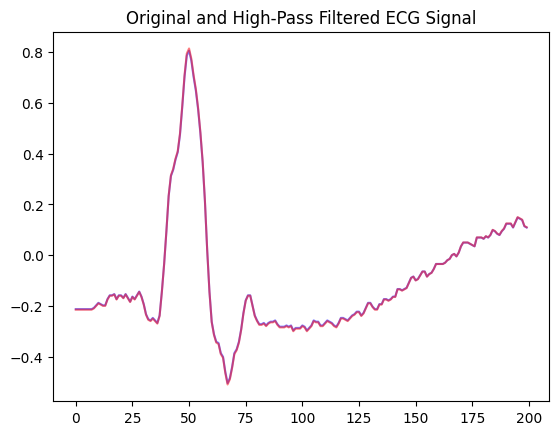

In [137]:

orig_sig = sig.copy()   
sig = apply_high_pass_filter(sig, 0.6, rec.fs, order=3)

# Plot the signal
plt.plot(sig[:200, 0], alpha=0.5, c="b")
plt.plot(orig_sig[:200, 0], alpha=0.5, c="r")
plt.title("Original and High-Pass Filtered ECG Signal")
# Plot the annotations
plt.show()

In [138]:
sample_len = len(sig)

fs = rec.fs  # Sampling frequency
signal = sig[:sample_len, 1]  # Example signal

# Step 1: Apply the Haar-like matched filter
fil = create_haar_like_filter(fs)
delay_smp, delay_time = calculate_convolution_delay(fil, fs)

print("Signal delayed by", delay_smp, "samples.")

filtered_signal = apply_matched_filter(signal, fs)
# filtered_signal = filtered_signal / np.max(filtered_signal)                 # Normalize the filtered signal
filtered_signal = [0 for i in range(delay_smp)] + list(filtered_signal)     # Add delay to the filtered signal
filtered_signal = filtered_signal[:sample_len]                                    # Truncate the filtered signal
filtered_signal = np.array(filtered_signal)

# Step 2: Calculate the second-order difference
second_diff = second_order_difference(signal)

# Step 3: Calculate the score function
score = calculate_score(second_diff, filtered_signal, second_diff)

# Step 4: Sift R-wave candidates
# r_wave_candidates = sift_r_wave_candidates(score, fs, threshold=np.max(score)/150)
r_wave_candidates = sift_r_wave_candidates_dynamic(score, fs, percentile=80, min_value=np.max(score)/50)

# Output results
print("Filtered Signal:", filtered_signal)
print("Second-Order Difference:", second_diff)
print("Score Function:", score)
print("R-wave Peak Candidates (indices):", r_wave_candidates)
print(max(score))


Signal delayed by 21 samples.
Filtered Signal: [ 0.          0.          0.         ... -3.67781855 -3.42772136
 -2.48185396]
Second-Order Difference: [ 0.          0.          0.         ... -0.00463703 -0.33565531
  0.        ]
Score Function: [ 0.          0.          0.         ...  0.02643393  1.78332597
 -0.        ]
R-wave Peak Candidates (indices): [57, 332, 843, 1107, 1594, 1841, 2348, 2616, 2755, 3123, 3381, 3501, 3863, 4120, 4645, 4914, 5416, 5677, 6167, 6434, 6947, 7222, 7708, 7964, 8092, 8442, 8723, 9220, 9487, 9784, 9961, 10222, 10696, 10965, 11458, 11721, 12105, 12205, 12460, 12609, 12724, 12946, 13232, 13367, 13510, 13731, 13986, 14120, 14265, 14537, 14772, 14924, 15053, 15296, 15419, 15524, 15668, 15805, 15943, 16021, 16230, 16347, 16468, 16588, 16855, 16981, 17059, 17199, 17434, 17732, 17818, 17984, 18077, 18248, 18391, 18500, 18827, 19072, 19206, 19580, 19830, 19993, 20091, 20198, 20361, 20549, 20660, 20767, 20946, 21072, 21212, 21333, 21453, 21626, 21776, 22124, 222

In [139]:
len(r_wave_candidates), np.max(score)/10

(3136, 0.1783325966306002)

Adaptive Threshold: 0.0027505006556829545


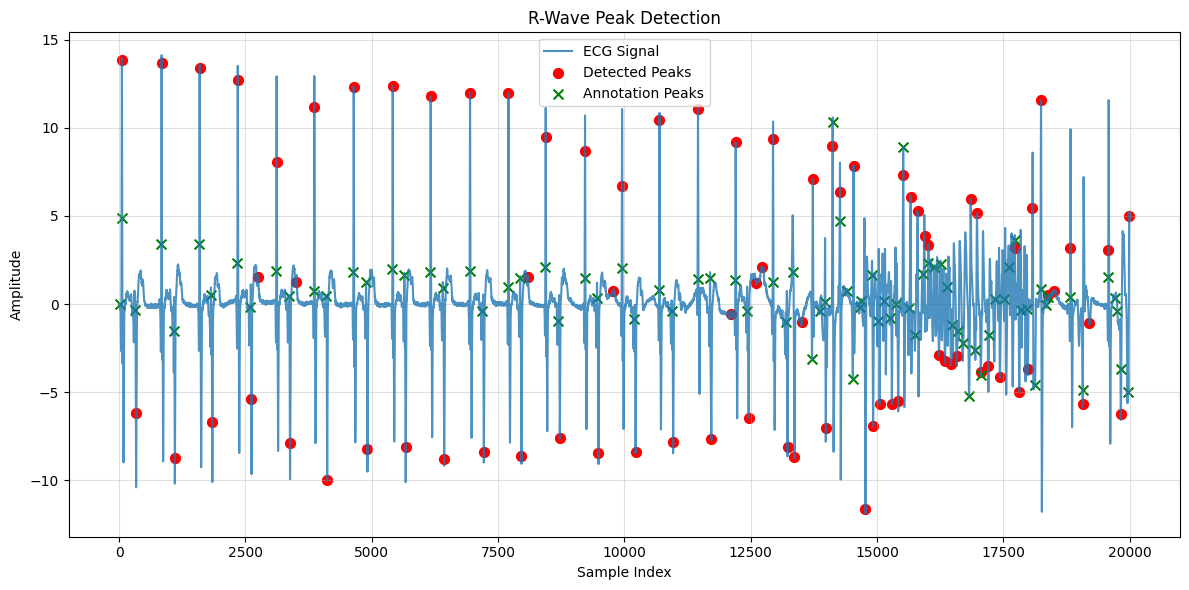

3136

In [140]:
# Compute the adaptive threshold and refine candidates
refined_r_wave_candidates = refine_r_wave_candidates(
    score, r_wave_candidates, fs, 
    lambda score, peaks, fs: calculate_adaptive_threshold(score, peaks, fs, T=.02, beta1=.0001, beta2=.001)
)
lim = 20_000
plot_detected_peaks(filtered_signal[:lim], refined_r_wave_candidates, fs, ann.sample[:len(refined_r_wave_candidates)])
len(refined_r_wave_candidates)

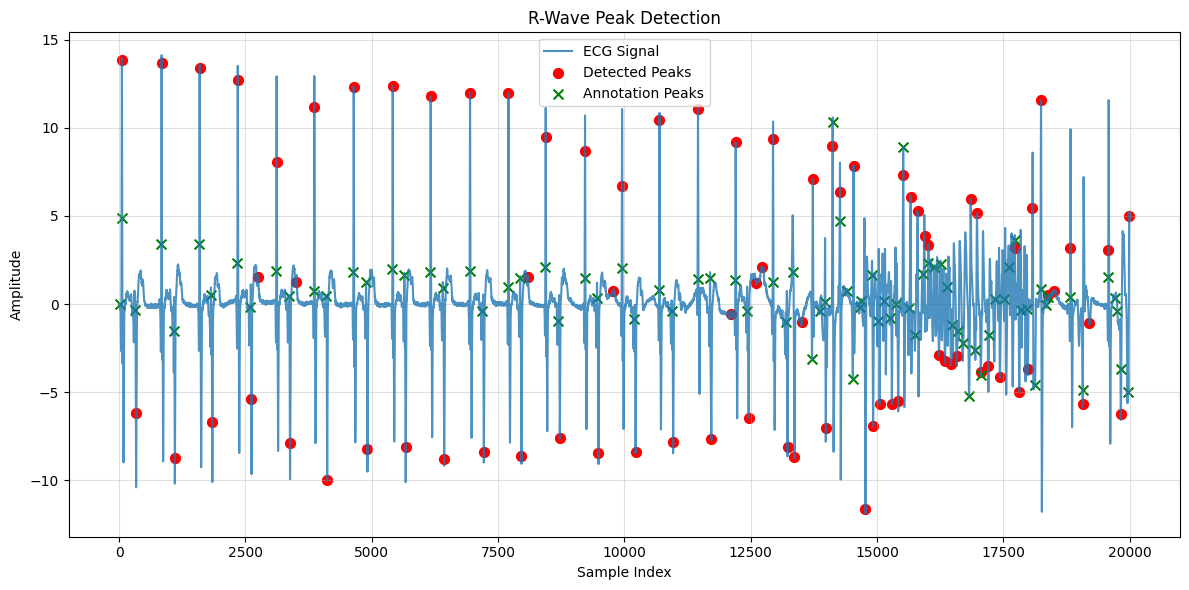

In [141]:
plot_detected_peaks(filtered_signal[:lim], r_wave_candidates, fs, ann.sample[:len(refined_r_wave_candidates)])


[57, 332, 843, 1107, 1594, 1841, 2348, 2616, 2755, 3123, 3381, 3501, 3863, 4120, 4645, 4914, 5416, 5677, 6167, 6434, 6947, 7222, 7708, 7964, 8092, 8442, 8723, 9220, 9487, 9784, 9961, 10222, 10696, 10965, 11458, 11721, 12105, 12205, 12460, 12609, 12724, 12946, 13232, 13367, 13510, 13731, 13986, 14120, 14265, 14537, 14772, 14924, 15053, 15296, 15419, 15524, 15668, 15805, 15943, 16021, 16230, 16347, 16468, 16588, 16855, 16981, 17059, 17199, 17434, 17732, 17818, 17984, 18077, 18248, 18500, 18827, 19072, 19206, 19580, 19830, 19993, 20091, 20198, 20361, 20549, 20660, 20767, 20946, 21072, 21212, 21333, 21453, 21626, 21776, 22124, 22248, 22381, 22513, 22667, 22890, 23027, 23190, 23354, 23512, 23762, 24184, 24365, 24550, 24881, 25036, 25198, 25347, 25510, 25776, 26176, 26430, 26556, 26817, 27071, 27464, 27799, 28055, 28194, 28320, 28724, 28990, 29120, 29232, 29461, 29858, 30105, 30200, 30572, 30848, 31267, 31627, 31774, 31957, 32300, 32652, 32998, 33357, 33608, 34002, 34361, 34509, 34720, 35087

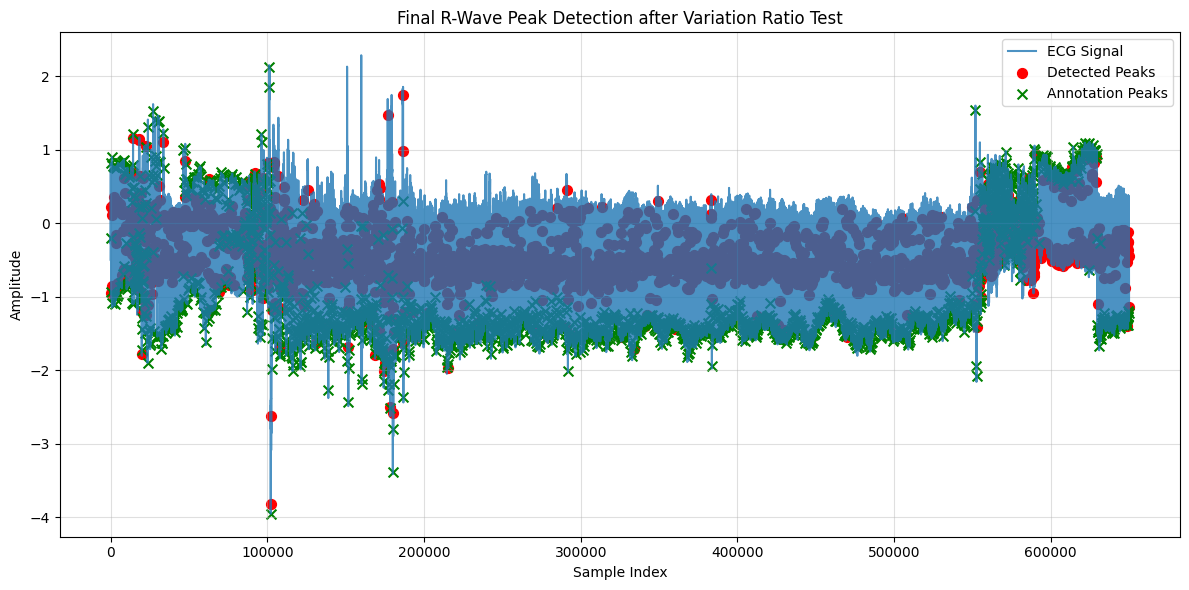

In [142]:

# Perform Variation Ratio Test
refined_peaks_variation_test = variation_ratio_test(
    signal=signal, 
    peak_candidates=refined_r_wave_candidates, 
    fs=fs, 
    window=0.2,
    threshold=0.2
)


print(refined_peaks_variation_test)

# Plot the final detected peaks
plot_detected_peaks(
    signal=orig_sig[:,0], 
    peak_indices=refined_peaks_variation_test,
    fs=fs, 
    ann=ann.sample[:len(refined_peaks_variation_test)+1], 
    title="Final R-Wave Peak Detection after Variation Ratio Test"
)


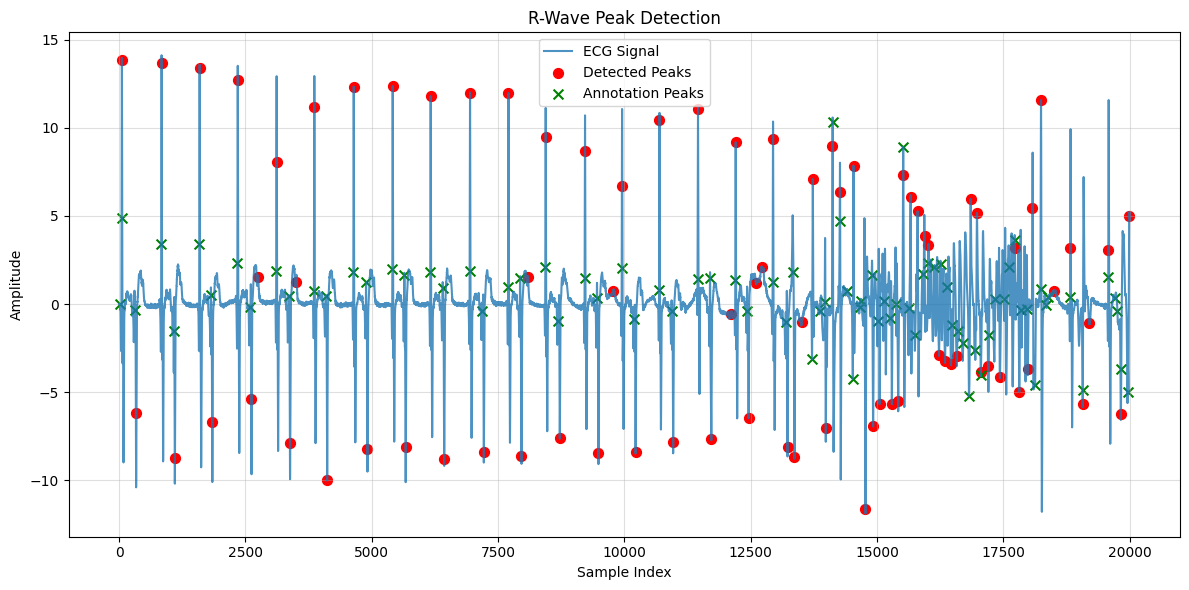

In [143]:
plot_detected_peaks(filtered_signal[:lim], refined_peaks_variation_test, fs, ann.sample[:len(refined_r_wave_candidates)])

In [156]:
[i for i in ann.sample if i > 15000 and i < 17500]

[15018,
 15138,
 15258,
 15387,
 15519,
 15642,
 15759,
 15906,
 16015,
 16138,
 16262,
 16383,
 16496,
 16611,
 16710,
 16822,
 16936,
 17055,
 17218,
 17346]

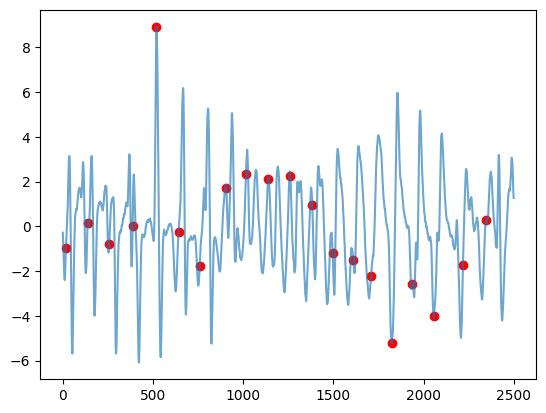

In [193]:
start, stop = 15000, 17500

# plt.plot(filtered_signal[start:stop], alpha=.65)
# plt.scatter([i-start for i in ann.sample if i > start and i < stop], [orig_sig[i, 0]*10 for i in ann.sample if i > start and i < stop], c="r")
plt.scatter([i-start for i in ann.sample if i > start and i < stop], [filtered_signal[i] for i in ann.sample if i > start and i < stop], c="r")

# plt.plot(orig_sig[start:stop, 0]*10, alpha=.65)
plt.plot(filtered_signal[start:stop], alpha=.65)



In [144]:
len(ann.sample), len(sig[ann.sample]), sig[ann.sample] 

(2385,
 2385,
 array([[-0.19791652,  0.11299922],
        [ 0.80650983,  1.0518578 ],
        [-0.92031183,  0.37057671],
        ...,
        [-1.18749914, -0.44023302],
        [-1.26171784, -0.5524806 ],
        [-1.20729079, -0.60804755]]))

In [145]:
def sensitivity(tp, fn):
    """
    Calculate the Sensitivity (SE) metric.
    
    SE = TP / (TP + FN)
    """
    return (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0  # Avoid division by zero


def positive_prediction(tp, fp):
    """
    Calculate the Positive Prediction (+P) metric.
    
    +P = TP / (TP + FP)
    """
    return (tp / (tp + fp)) * 100 if (tp + fp) > 0 else 0  # Avoid division by zero


def detection_error_rate(tp, fn, fp):
    """
    Calculate the Detection Error Rate (DER) metric.
    
    DER = (FP + FN) / (TP + FN)
    """
    return ((fp + fn) / (tp + fn)) * 100 if (tp + fn) > 0 else 0  # Avoid division by zero

In [146]:
def get_metrics(labels, detections, offset_threshold):
    """
    Calculate the performance metrics (Sensitivity, Positive Prediction, and Detection Error Rate)
    by comparing the detected R-wave peaks with the ground truth labels.
    
    Parameters:
    - labels: Ground truth R-wave peak locations.
    - detections: Detected R-wave peak locations.
    - offset_threshold: The maximum allowable offset (in samples) for a detection to be considered a match to a label.

    Returns:
    - tp: Number of True Positives.
    - fn: Number of False Negatives.
    - fp: Number of False Positives.
    """
    tp = 0  # True positives
    fn = 0  # False negatives
    fp = 0  # False positives

    unmatched_detections = detections.copy()  # Copy of detections to remove matched ones

    # Calculate True Positives (TP) and False Negatives (FN)
    for label in labels:
        matched = False
        for detection in detections:
            if abs(label - detection) <= offset_threshold:  # Considered a match if within the offset threshold
                tp += 1
                matched = True
                unmatched_detections.remove(detection)  # Remove matched detection from the list
                break
        if not matched:
            fn += 1  # If no match is found, it's a false negative

    # Calculate False Positives (FP)
    for detection in unmatched_detections:
        fp += 1  # Any unmatched detection is a false positive

    # Calculate Sensitivity (SE), Positive Prediction (+P), and Detection Error Rate (DER)
    sensitivity_value = sensitivity(tp, fn)
    positive_prediction_value = positive_prediction(tp, fp)
    detection_error_rate_value = detection_error_rate(tp, fn, fp)

    print(f"Sensitivity (SE): {sensitivity_value:.2f}%")
    print(f"Positive Prediction (+P): {positive_prediction_value:.2f}%")
    print(f"Detection Error Rate (DER): {detection_error_rate_value:.3f}%")

    return tp, fn, fp




In [147]:
len(refined_peaks_variation_test)

2548

In [148]:
labels = ann.sample#[1:]
get_metrics(labels, refined_peaks_variation_test, 10)

Sensitivity (SE): 17.15%
Positive Prediction (+P): 16.05%
Detection Error Rate (DER): 172.537%


(409, 1976, 2139)